# Instance segmentation with Retinanet/MaskRCNN 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras.optimizers import SGD
from tensorflow.python.keras import backend as K
from skimage.measure import regionprops
from skimage.segmentation import clear_border

from deepcell import get_data
from deepcell import rate_scheduler
from deepcell.utils.retinanet_anchor_utils import anchor_targets_bbox

# from keras_maskrcnn.preprocessing.generator import Generator as _MaskRCNNGenerator

Using TensorFlow backend.


## Load data

X_train shape: (22, 40, 216, 256, 1)
y_train shape: (22, 40, 216, 256, 1)


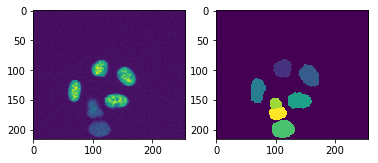

In [2]:
data = np.load('/data/npz_data/cells/HeLa/S3/movie/nuclear_movie_hela0_same.npz')
train_dict, val_dict = get_data('/data/npz_data/cells/HeLa/S3/movie/nuclear_movie_hela0_same.npz', mode='conv')
print('X_train shape:', train_dict['X'].shape)
print('y_train shape:', train_dict['y'].shape)

fig,ax = plt.subplots(1,2)
ax[0].imshow(train_dict['X'][0,0,:,:,0])
ax[1].imshow(train_dict['y'][0,0,:,:,0])

## Create image generator

In [3]:
import numpy as np
import random
import threading
import warnings

import keras

from keras_retinanet.utils.anchors import (
    anchor_targets_bbox,
    bbox_transform,
    anchors_for_shape,
    guess_shapes
)
from keras_retinanet.utils.image import (
    TransformParameters,
    adjust_transform_for_image,
    apply_transform,
    preprocess_image,
    resize_image,
)
from keras_retinanet.utils.transform import transform_aabb


class Generator(object):
    def __init__(
        self,
        transform_generator = None,
        batch_size=1,
        group_method='ratio',  # one of 'none', 'random', 'ratio'
        shuffle_groups=True,
        image_min_side=800,
        image_max_side=1333,
        transform_parameters=None,
        compute_shapes=guess_shapes,
        compute_anchor_targets=anchor_targets_bbox,
    ):
        self.transform_generator    = transform_generator
        self.batch_size             = int(batch_size)
        self.group_method           = group_method
        self.shuffle_groups         = shuffle_groups
        self.image_min_side         = image_min_side
        self.image_max_side         = image_max_side
        self.transform_parameters   = transform_parameters or TransformParameters()
        self.compute_shapes         = compute_shapes
        self.compute_anchor_targets = compute_anchor_targets

        self.group_index = 0
        self.lock        = threading.Lock()

        self.group_images()

    def size(self):
        raise NotImplementedError('size method not implemented')

    def num_classes(self):
        raise NotImplementedError('num_classes method not implemented')

    def name_to_label(self, name):
        raise NotImplementedError('name_to_label method not implemented')

    def label_to_name(self, label):
        raise NotImplementedError('label_to_name method not implemented')

    def image_aspect_ratio(self, image_index):
        raise NotImplementedError('image_aspect_ratio method not implemented')

    def load_image(self, image_index):
        raise NotImplementedError('load_image method not implemented')

    def load_annotations(self, image_index):
        raise NotImplementedError('load_annotations method not implemented')

    def load_annotations_group(self, group):
        return [self.load_annotations(image_index) for image_index in group]

    def filter_annotations(self, image_group, annotations_group, masks_group, group):
        # test all annotations
        for index, (image, annotations, masks) in enumerate(zip(image_group, annotations_group, masks_group)):
            assert(isinstance(annotations, np.ndarray)), '\'load_annotations\' should return a list of numpy arrays, received: {}'.format(type(annotations))

            # check if all masks have the same size of the respective image
            for idx in range(len(masks)):
                assert(image.shape[:2] == masks[idx].shape[:2]), 'Found different image ({}) and mask ({}) size in image {}'.format(image.shape, masks[idx].shape, group[index])

            # test x2 < x1 | y2 < y1 | x1 < 0 | y1 < 0 | x2 <= 0 | y2 <= 0 | x2 >= image.shape[1] | y2 >= image.shape[0]
            invalid_indices = np.where(
                (annotations[:, 2] <= annotations[:, 0]) |
                (annotations[:, 3] <= annotations[:, 1]) |
                (annotations[:, 0] < 0) |
                (annotations[:, 1] < 0) |
                (annotations[:, 2] > image.shape[1]) |
                (annotations[:, 3] > image.shape[0]) |
                (np.sum(masks, axis=(1,2,3)) == 0)
            )[0]

            # delete invalid indices
            if len(invalid_indices):
#                 warnings.warn('Image with id {} (shape {}) contains the following invalid boxes: {}.'.format(
#                     group[index],
#                     image.shape,
#                     [annotations[invalid_index, :] for invalid_index in invalid_indices]
#                 ))
                annotations_group[index] = np.delete(annotations, invalid_indices, axis=0)
                masks_group[index]       = np.delete(masks, invalid_indices, axis=0)

        return image_group, annotations_group, masks_group

    def load_image_group(self, group):
        return [self.load_image(image_index) for image_index in group]

    def random_transform_group_entry(self, image, annotations, masks):
        # randomly transform both image and annotations
        if self.transform_generator:
            transform = adjust_transform_for_image(next(self.transform_generator), image, self.transform_parameters.relative_translation)
            image     = apply_transform(transform, image, self.transform_parameters)

            if len(image.shape) == 2:
                image = np.expand_dims(image, axis=-1)
                
            # randomly transform the masks and expand so to have a fake channel dimension
            for m in range(len(masks)):
                masks[m] = apply_transform(transform, masks[m], self.transform_parameters)
                masks[m] = np.expand_dims(masks[m], axis=-1)

            # randomly transform the bounding boxes
            annotations = annotations.copy()
            for index in range(annotations.shape[0]):
                annotations[index, :4] = transform_aabb(transform, annotations[index, :4])

        return image, annotations, masks

    def resize_image(self, image):
        resized_image, scale = resize_image(image, min_side=self.image_min_side, max_side=self.image_max_side)
        if len(resized_image.shape) == 2:
            resized_image = np.expand_dims(resized_image, axis=-1)
        return resized_image, scale
        
    def preprocess_image(self, image):
        return image

    def preprocess_group_entry(self, image, annotations, masks):
        # preprocess the image
        image = self.preprocess_image(image)

        # randomly transform image and annotations
        image, annotations, masks = self.random_transform_group_entry(image, annotations, masks)

        # resize image
        image, image_scale = self.resize_image(image)

        # resize masks
        for i in range(len(masks)):
            masks[i], _ = self.resize_image(masks[i])

        # apply resizing to annotations too
        annotations[:, :4]  *= image_scale

        return image, annotations, masks

    def preprocess_group(self, image_group, annotations_group, masks_group):
        for index, (image, annotations, masks) in enumerate(zip(image_group, annotations_group, masks_group)):
            # preprocess a single group entry
            image, annotations, masks = self.preprocess_group_entry(image, annotations, masks)

            # copy processed data back to group
            image_group[index]       = image
            annotations_group[index] = annotations
            masks_group[index]       = masks

        return image_group, annotations_group, masks_group

    def group_images(self):
        # determine the order of the images
        order = list(range(self.size()))
        if self.group_method == 'random':
            random.shuffle(order)
        elif self.group_method == 'ratio':
            order.sort(key=lambda x: self.image_aspect_ratio(x))

        # divide into groups, one group = one batch
        self.groups = [[order[x % len(order)] for x in range(i, i + self.batch_size)] for i in range(0, len(order), self.batch_size)]

    def compute_inputs(self, image_group):
        # get the max image shape
        max_shape = tuple(max(image.shape[x] for image in image_group) for x in range(3))

        # construct an image batch object
        image_batch = np.zeros((self.batch_size,) + max_shape, dtype=keras.backend.floatx())

        # copy all images to the upper left part of the image batch object
        for image_index, image in enumerate(image_group):
            image_batch[image_index, :image.shape[0], :image.shape[1], :image.shape[2]] = image

        return image_batch

    def generate_anchors(self, image_shape):
        return anchors_for_shape(image_shape, shapes_callback=self.compute_shapes)

    def compute_targets(self, image_group, annotations_group, masks_group):
        """ Compute target outputs for the network using images and their annotations.
        """
        # get the max image shape
        max_shape = tuple(max(image.shape[x] for image in image_group) for x in range(3))
        anchors   = self.generate_anchors(max_shape)

        labels_batch, regression_batch, _ = self.compute_anchor_targets(
            anchors,
            image_group,
            annotations_group,
            self.num_classes()
        )

        # copy all annotations / masks to the batch
        max_annotations = max(a.shape[0] for a in annotations_group)
        # masks_batch has shape: (batch size, max_annotations, bbox_x1 + bbox_y1 + bbox_x2 + bbox_y2 + prediction_label + width + height + max_image_dimension)
        masks_batch     = np.zeros((self.batch_size, max_annotations, 5 + 2 + max_shape[0] * max_shape[1]), dtype=keras.backend.floatx())
        for index, (annotations, masks) in enumerate(zip(annotations_group, masks_group)):
            masks_batch[index, :annotations.shape[0], :annotations.shape[1]] = annotations
            masks_batch[index, :, 5] = max_shape[1]  # width
            masks_batch[index, :, 6] = max_shape[0]  # height

            # add flattened mask
            for mask_index, mask in enumerate(masks):
                masks_batch[index, mask_index, 7:] = mask.flatten()

        return [regression_batch, labels_batch, masks_batch]

    def compute_input_output(self, group):
        # load images and annotations
        image_group       = self.load_image_group(group)
        annotations_group = self.load_annotations_group(group)

        # split annotations and masks
        masks_group       = [m for _, m in annotations_group]
        annotations_group = [a for a, _ in annotations_group]

        # perform preprocessing steps
        image_group, annotations_group, masks_group = self.preprocess_group(image_group, annotations_group, masks_group)

        # check validity of annotations again - augmentations can cause cells to disappear
        image_group, annotations_group, masks_group = self.filter_annotations(image_group, annotations_group, masks_group, group)

        # compute network inputs
        inputs = self.compute_inputs(image_group)

        # compute network targets
        targets = self.compute_targets(image_group, annotations_group, masks_group)

        return inputs, targets

    def __next__(self):
        return self.next()

    def next(self):
        # advance the group index
        with self.lock:
            if self.group_index == 0 and self.shuffle_groups:
                # shuffle groups at start of epoch
                random.shuffle(self.groups)
            group = self.groups[self.group_index]
            self.group_index = (self.group_index + 1) % len(self.groups)

        return self.compute_input_output(group)

In [18]:
class MaskRCNNGenerator(Generator):
    def __init__(self,
                 train_dict,
                 image_min_side=200,
                 image_max_side=200,
                 data_format=None,
                 **kwargs):

        if data_format is None:
            data_format = K.image_data_format()
        self.data_format = data_format
        
        self.channel_axis = -1 if data_format == 'channels_last' else 1
        self.row_axis = 1 if data_format == 'channels_last' else 2
        self.col_axis = 2 if data_format == 'channels_last' else 3
        
        self.x = train_dict['X']
        self.y = train_dict['y']
        
        if len(self.x.shape) == 5:
            x,y = self.x, self.y
            if self.data_format == 'channels_last':
                new_shape = (x.shape[0]*x.shape[1], x.shape[2], x.shape[3], x.shape[4])
            else:
                new_shape = (x.shape[0]*x.shape[2], x.shape[1], x.shape[3], x.shape[4])
            x_temp = np.reshape(x, new_shape)
            y_temp = np.reshape(y, new_shape)
            
            self.x = x_temp
            self.y = y_temp
                        
        # Make images square
        if self.x.shape[self.row_axis] != self.x.shape[self.col_axis]:
            axis_shape = np.amin([self.x.shape[self.row_axis], self.x.shape[self.col_axis]])
            
            if data_format == 'channels_last':
                self.x = self.x[:,0:axis_shape,0:axis_shape,:]
                self.y = self.y[:,0:axis_shape,0:axis_shape,:]
            else:
                self.x = self.x[:,:,0:axis_shape,0:axis_shape]
                self.y = self.y[:,:,0:axis_shape,0:axis_shape] 
                
        # Remove border cells
        for b in range(self.y.shape[0]):
            if self.data_format == 'channels_last':
                y_batch = self.y[b,:,:,0]
            else:
                y_batch = self.y[b,0,:,:]
            self.y[b] = np.expand_dims(clear_border(y_batch), axis=self.channel_axis)
        
        good_batch = []
        # Remove images with small numbers of cells
        for b in range(self.x.shape[0]):
            n_cells = len(np.unique(self.y[b]))-1
            if n_cells > 3:
                good_batch.append(b)
                
        good_batch = np.array(good_batch)
        self.x = self.x[good_batch,:,:,:]
        self.y = self.y[good_batch,:,:,:]
        
        self.classes = {'cell': 0}
        self.labels = {}
        for key, value in self.classes.items():
            self.labels[value] = key

        self.image_data = self._read_annotations(self.y)
        self.image_names = list(self.image_data.keys())

        # Override default Generator value with custom anchor_targets_bbox
        if 'compute_anchor_targets' not in kwargs:
            kwargs['compute_anchor_targets'] = anchor_targets_bbox

        super(MaskRCNNGenerator, self).__init__(
            image_min_side=image_min_side,
            image_max_side=image_max_side,
            **kwargs)

    def _read_annotations(self, maskarr):
        result = {}
        for cnt, l in enumerate(maskarr):
            result[cnt] = []
            p = regionprops(l)
            cell_count = 0
            cell_labels = np.unique(l[l>0])
            for index in range(len(cell_labels)):
                y1, x1, y2, x2 = p[index].bbox
                cell_label = p[index].label
                result[cnt].append({
                    'x1': x1,
                    'x2': x2,
                    'y1': y1,
                    'y2': y2,
                    'class': 'cell',
                    'mask_path': np.where(l == cell_label, 1, 0)
                })
                cell_count += 1
#             print('Image number {} has {} cells'.format(cnt, cell_count))
            # If there are no cells in this image, remove it from the annotations
            if not result[cnt]:
                del result[cnt]
        return result

    def size(self):
        return len(self.image_names)

    def num_classes(self):
        return max(self.classes.values()) + 1

    def name_to_label(self, name):
        return self.classes[name]

    def label_to_name(self, label):
        return self.labels[label]

    def image_path(self, image_index):
        return os.path.join(self.base_dir, self.image_names[image_index])

    def image_aspect_ratio(self, image_index):
        image = self.x[image_index]
        return float(image.shape[1]) / float(image.shape[0])

    def load_image(self, image_index):
        return self.x[image_index]

    def load_annotations(self, image_index):
        annots = self.image_data[image_index]

        # find mask size in order to allocate the right dimension for the annotations
        annotations = np.zeros((len(annots), 5))
        masks = []

        for idx, annot in enumerate(annots):
            annotations[idx, 0] = float(annot['x1'])
            annotations[idx, 1] = float(annot['y1'])
            annotations[idx, 2] = float(annot['x2'])
            annotations[idx, 3] = float(annot['y2'])
            annotations[idx, 4] = self.name_to_label(annot['class'])
            mask = annot['mask_path']
            mask = (mask > 0).astype(np.uint8)  # convert from 0-255 to binary mask
            masks.append(mask)
            
        return annotations, masks

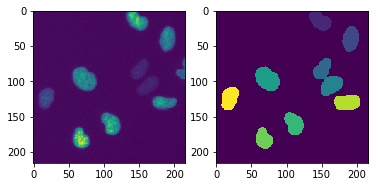

In [39]:
from keras_retinanet.utils.transform import random_transform_generator

transform_generator = random_transform_generator(flip_x_chance=0.5,
                                                 flip_y_chance=0.5,
                                                 min_rotation=-np.pi/4,
                                                 max_rotation=np.pi/4,
                                                 min_translation=[-0.2,-0.2],
                                                 max_translation=[0.2,0.2],
                                                 min_scaling=[0.8,0.8],
                                                 max_scaling=[1.2,1.2])
test_generator = MaskRCNNGenerator(train_dict, batch_size=1, group_method='random', transform_generator=transform_generator)
test_generator_2 = MaskRCNNGenerator(val_dict, batch_size=1, group_method='random')
batch = 200
n_masks = len(test_generator.image_data[batch])
fig,ax = plt.subplots(1,2)
ax[0].imshow(test_generator.x[batch,:,:,0])
mask_sum = np.zeros(test_generator.image_data[batch][0]['mask_path'][:,:,0].shape)
for j in range(n_masks):
    mask_sum += (j+1)*test_generator.image_data[batch][j]['mask_path'][:,:,0]
ax[1].imshow(mask_sum)


## Construct retinanet model

In [40]:
from keras_maskrcnn.models.retinanet import retinanet_mask

from keras.layers import Input
from keras_retinanet.models import retinanet
from keras.layers import Conv2D, MaxPool2D, BatchNormalization, Activation
from keras.models import Model
from deepcell.layers import ImageNormalization2D


def tempnetwork(inputs):
    """
    Retinanet uses feature pyramid networks(FPN) which combines features from
    different scales in the nueral network to obtain a better understanding
    of the image.

    Retinanet requires 3 features from the backbone called C3 , C4 and C5.

    Now the scaling here is as follows:
        If the model inputs are of the form -: Inputs : (x, x, 3)
        then  Cn = (x // (2^n), x // (2^n), None)
        Here a // b denotes rounding the float (a / b) to the largest integer.
    """
    
#     norm = ImageNormalization2D(norm_method='std')(inputs)
    conv1 = Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = BatchNormalization(axis=-1)(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization(axis=-1)(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPool2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = BatchNormalization(axis=-1)(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization(axis=-1)(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPool2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = BatchNormalization(axis=-1)(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(conv3)
    conv3 = BatchNormalization(axis=-1)(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPool2D(pool_size=(2, 2))(conv3)
   
    conv4 = Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = BatchNormalization(axis=-1)(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(64, 3, padding='same', kernel_initializer='he_normal', name='deepcell1')(conv4)
    conv4 = BatchNormalization(axis=-1)(conv4)
    conv4 = Activation('relu')(conv4)
    pool4 = MaxPool2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = BatchNormalization(axis=-1)(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Conv2D(64, 3, padding='same', kernel_initializer='he_normal', name='deepcell2')(conv5)
    conv5 = BatchNormalization(axis=-1)(conv5)
    conv5 = Activation('relu')(conv5)
    pool5 = MaxPool2D(pool_size=(2, 2))(conv5)

    conv6 = Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(pool5)
    conv6 = BatchNormalization(axis=-1)(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Conv2D(64, 3, padding='same', kernel_initializer='he_normal', name='deepcell3')(conv6)
    conv6 = BatchNormalization(axis=-1)(conv6)
    conv6 = Activation('relu')(conv6)
    
    model = Model(inputs=inputs, outputs=conv6)

    return model


def deepcell_retinanet_mask(num_classes, backbone='deepcell', inputs=None, modifier=None, **kwargs):
    """ Constructs a retinanet model using the custom backbone.
    # Args
        num_classes: Number of classes to predict.
        backbone: Our custom backbone.
        inputs: The inputs to the network (defaults to a Tensor of shape (None, None, 3)).
        modifier: A function handler which can modify the backbone.
                  It could be used to freeze the training of the backbone.
    # Returns
        RetinaNet model with a custom backbone.
    """
    # choose default input
    if inputs is None:
        inputs = Input(shape=(None, None, 1))

    # Call the custom model
    modeltest = tempnetwork(inputs)
    # Make an array of the names of the layers we want
    layer_names = ['deepcell1', 'deepcell2', 'deepcell3']
    # Get the required layers
    layer_outputs = [modeltest.get_layer(name).output for name in layer_names]
    backbone = Model(inputs=inputs, outputs=layer_outputs, name='deepcell')

    # create the full model
    return retinanet_mask(
        inputs=inputs,
        num_classes=num_classes,
        backbone_layers=backbone.outputs,
        **kwargs)


## Train retinanet model

In [41]:
from keras_retinanet.callbacks import RedirectModel
from keras_maskrcnn.callbacks.eval import Evaluate

def create_callbacks(model, training_model, prediction_model, validation_generator):
    callbacks = []
    tensorboard_callback = None
    if validation_generator:
        evaluation = Evaluate(validation_generator, tensorboard=tensorboard_callback)
        evaluation = RedirectModel(evaluation, prediction_model)
        callbacks.append(evaluation)

    callbacks.append(keras.callbacks.ReduceLROnPlateau(
        monitor  = 'loss',
        factor   = 0.1,
        patience = 2,
        verbose  = 1,
        mode     = 'auto',
        epsilon  = 0.0001,
        cooldown = 0,
        min_lr   = 0
    ))

    return callbacks

In [ ]:
from keras_retinanet.utils.transform import random_transform_generator
from keras_maskrcnn.bin.train import create_models
transform_generator = random_transform_generator(flip_x_chance=0.5,
                                                 flip_y_chance=0.5,
                                                 min_rotation=-np.pi,
                                                 max_rotation=np.pi,
                                                 min_translation=[-0.2,-0.2],
                                                 max_translation=[0.2,0.2],
                                                 min_scaling=[0.8,0.8],
                                                 max_scaling=[1.2,1.2])

train_generator = MaskRCNNGenerator(train_dict, batch_size=16, group_method='random', 
                                    transform_generator=transform_generator)
val_generator = MaskRCNNGenerator(val_dict, batch_size=16, group_method='random')

model, training_model, prediction_model = create_models(
            backbone_retinanet=deepcell_retinanet_mask,
            num_classes=train_generator.num_classes(),
            weights=None,
            freeze_backbone=False,
            class_specific_filter=True)

callbacks = create_callbacks(
        model,
        training_model,
        prediction_model,
        val_generator)

training_model.fit_generator(
        generator=train_generator,
        steps_per_epoch=2000,
        epochs=20,
        verbose=1,
        callbacks=callbacks,
        max_queue_size=1)

/usr/local/lib/python3.5/dist-packages/keras_maskrcnn/bin/train.py:77: UserWarning: Output "filtered_detections" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "filtered_detections" during training.
  optimizer=keras.optimizers.adam(lr=1e-5, clipnorm=0.001)
/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:999: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '
/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/20
2000/2000 [==============================] - 823s 412ms/step - loss: 1.9078 - regression_loss: 1.2980 - classification_loss: 0.2898 - boxes_masks_loss: 0.3199
280 instances of class cell with average precision: 0.9513
mAP: 0.9513
Epoch 2/20
2000/2000 [==============================] - 798s 399ms/step - loss: 1.2415 - regression_loss: 0.8768 - classification_loss: 0.1479 - boxes_masks_loss: 0.2168
280 instances of class cell with average precision: 0.9314
mAP: 0.9314
Epoch 3/20
2000/2000 [==============================] - 805s 403ms/step - loss: 1.1543 - regression_loss: 0.8186 - classification_loss: 0.1335 - boxes_masks_loss: 0.2022
280 instances of class cell with average precision: 0.9498
mAP: 0.9498
Epoch 4/20
2000/2000 [==============================] - 817s 408ms/step - loss: 1.0976 - regression_loss: 0.7853 - classification_loss: 0.1219 - boxes_masks_loss: 0.1904
280 instances of class cell with average precision: 0.9771
mAP: 0.9771
Epoch 5/20
2000/2000 [==============

## Evaluate retinanet model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


processing time:  0.11442017555236816
(200, 200, 3)


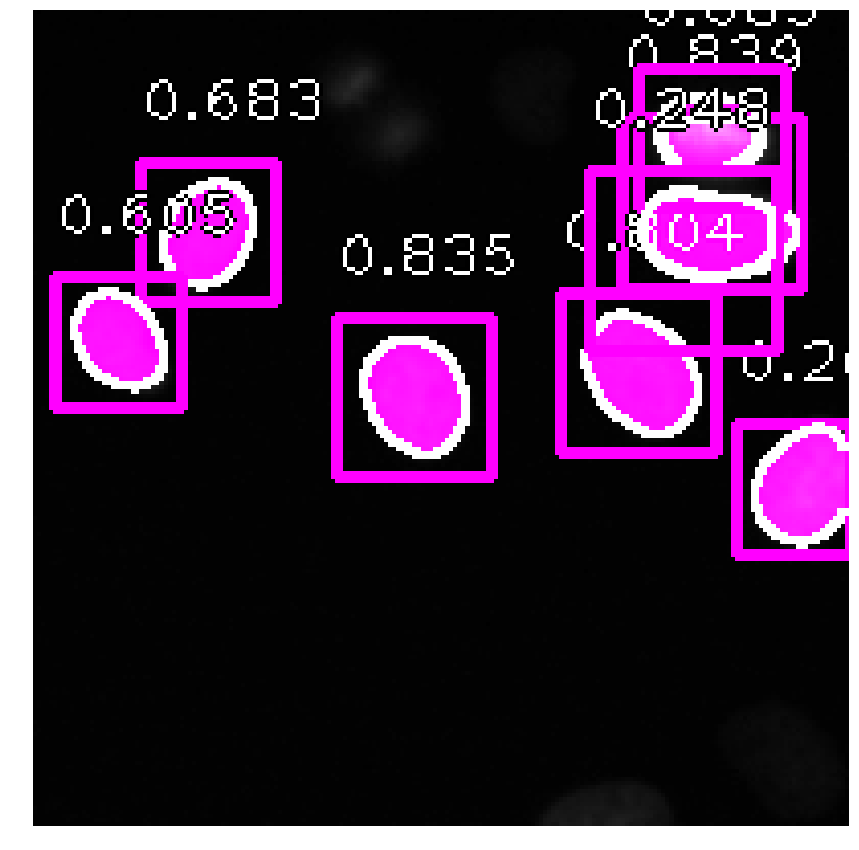

In [147]:
from keras_maskrcnn import models
from keras_maskrcnn.utils.visualization import draw_mask
from keras_retinanet.utils.visualization import draw_box, draw_caption, draw_annotations
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

image = val_generator.next()[0][[0],:,:,:]
start = time.time()
outputs = model.predict_on_batch(image)
print('processing time: ', time.time() - start)

boxes  = outputs[-4][0]
scores = outputs[-3][0]
labels = outputs[-2][0]
masks  = outputs[-1][0]

image=0.01*np.tile(np.expand_dims(image[0,:,:,0],axis=-1),(1,1,3))

# copy to draw on
draw = image.copy()
print(draw.shape)
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

for box, score, label, mask in zip(boxes, scores, labels, masks):
    if score < 0.2:
        break

    color = label_color(label)
    
    b = box.astype(int)
    draw_box(draw, b, color=color)
    
    mask = mask[:, :, label]
    draw_mask(draw, b, mask, color=label_color(label))
    
    caption = "{:.3f}".format(score)
    draw_caption(draw, b, caption)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()
